# Bandit Comparison: Zoom-In vs GP vs Standard Algorithms

### *Authors:* **Marvin Ernst, Oriol Gelabert, Melisa Vadenja**

Date: May 22, 2025

This notebook compares the performance of different bandit algorithms under a spatial Gaussian reward setting in 2D. We evaluate algorithms using instantaneous and cumulative regret metrics.

**Imports and setup:**

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..")))
from src import (
    generate_ground_truth,
    RegretTracker,
    GaussianUCB, GaussianTS,
    GaussianProcessUCB, GaussianProcessTS,
    get_zoomin_algorithm,
    plot_cumulative_regret, plot_instantaneous_regret, ensure_scalar, plot_arm_positions
)

**Simulation configuration:**

In [39]:
K = 5000 
T = 1000
D = 2
SIGMA = 0.001 # standard deviation of the noise in the reward distribution - VERY important for the performance of the algorithms!
N_RUNS = 1
LENGTH_SCALE = 1.0 # length scale for the GP prior = how quickly rewards chnage across space, highher = good arms are further from bad ones - very IMPORTANT!
SCALE_FACTOR = 20.0 # scale factor for the GP prior = how much the rewards vary across space, in total terms (not in distance (this is just a scalar)
BIAS = 29.0 # bias for the GP prior = how much the rewards are shifted up or down, in total terms (not in distance (this is just a constant)

### For the ZoomIn: ###

# smoothness constant: scale of the confidence radius - influences when a region is split. 
NU = 5.0   # smaller NU = more willing to split (i.e. assumes rewards change less across space) - we could make this up to 10 or bigger

# shrinking factor: how quickly regions shrink as the algorithm zooms in
RHO = 0.99 # smaller RHO = more aggressive shrinking

algorithms_to_compare = {
    "ZoomIn": lambda f, arms: get_zoomin_algorithm(f, domain=[[0, 1], [0, 1]], rounds=T, nu=NU, rho=RHO),
    #"GP-UCB": lambda f, arms: GaussianProcessUCB(arms), # here we could also try with different length scales
    #"GP-TS": lambda f, arms: GaussianProcessTS(arms), # here we could also try with different length scales
    "UCB":    lambda f, arms: GaussianUCB(K),
    "TS":     lambda f, arms: GaussianTS(K)
}

**Example Bandits Space:**

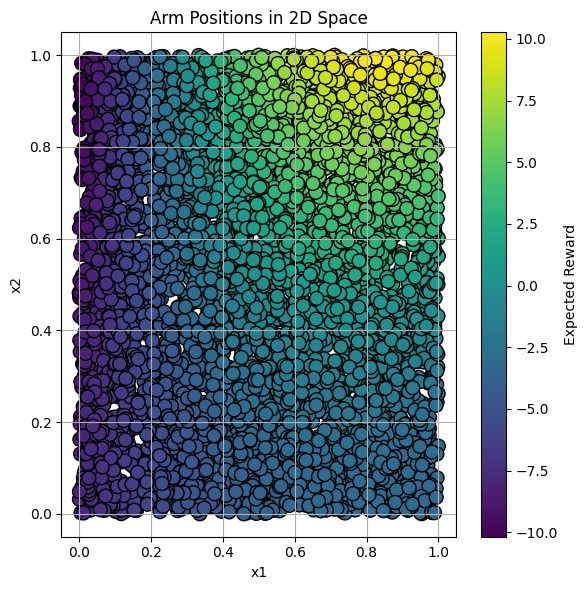

In [40]:
X, mu, f = generate_ground_truth(K=K, d=2, sigma=SIGMA, random_state=1, length_scale=LENGTH_SCALE, scale_factor=SCALE_FACTOR, bias=BIAS)
plot_arm_positions(X, mu)

**Run simulations:**


```
records = []

for run in trange(N_RUNS, desc="Simulation runs"):
    X, mu, f = generate_ground_truth(K=K, d=D, sigma=SIGMA, random_state=run, length_scale = LENGTH_SCALE, scale_factor=SCALE_FACTOR, bias=BIAS)

    for name, constructor in algorithms_to_compare.items():
        algo = constructor(f, X)
        tracker = RegretTracker(mu)

        for t in range(T):
            if name == "ZoomIn":
                x_t = algo.select_arm(t)
                x_array = np.atleast_2d(np.asarray(x_t, dtype=np.float64).flatten())
                a_t = np.argmin(np.linalg.norm(X - x_array, axis=1))
                reward = np.random.normal(f(x_array), SIGMA)
                algo.update(a_t, reward)
            else:
                a_t = algo.select_arm()
                reward = np.random.normal(mu[a_t], SIGMA) 
                algo.update(a_t, reward)

            tracker.update(a_t)

            records.append({
                'time': t + 1,
                'regret': tracker.get_cumulative_regret(),
                'algorithm': name,
                'run': run
            })
```


In [41]:
records = []

for run in trange(N_RUNS, desc="Simulation runs"):
    X, mu, f = generate_ground_truth(
        K=K, d=D, sigma=SIGMA, random_state=run,
        length_scale=LENGTH_SCALE, scale_factor=SCALE_FACTOR, bias=BIAS
    )

    for name, constructor in algorithms_to_compare.items():
        algo = constructor(f, X)
        tracker = RegretTracker(mu)

        for t in range(T):
            if name == "ZoomIn":
                x_t = algo.pull(t)
                x_array = np.atleast_2d(np.asarray(x_t, dtype=np.float64).flatten())
                a_t = np.argmin(np.linalg.norm(X - x_array, axis=1))
                reward = np.random.normal(f(x_array), SIGMA)
                algo.receive_reward(t, reward)
            else:
                a_t = algo.select_arm()
                reward = np.random.normal(mu[a_t], SIGMA)
                algo.update(a_t, reward)

            tracker.update(a_t)

            records.append({
                'time': t + 1,
                'regret': tracker.get_cumulative_regret(),
                'algorithm': name,
                'run': run
            })

Simulation runs: 100%|██████████| 1/1 [02:36<00:00, 156.50s/it]


**Convert and group data:**

In [42]:
df = pd.DataFrame(records)
df_avg = df.groupby(['algorithm', 'time']).regret.mean().reset_index()
df_avg.rename(columns={"regret": "avg_regret"}, inplace=True)
df_avg["avg_regret"] = df_avg["avg_regret"].apply(np.ravel).apply(lambda x: x[0] if isinstance(x, (np.ndarray, list)) else x)

**Plot cumulative regret:**

/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset

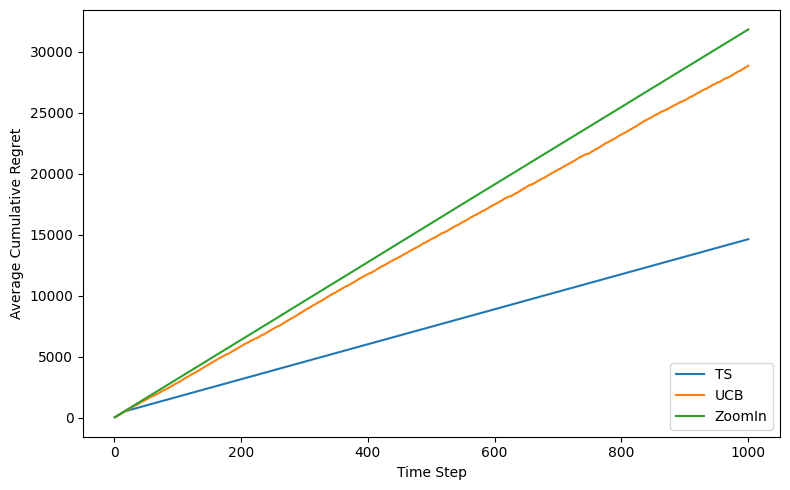

In [43]:
plot_cumulative_regret(df_avg)

**Instantaneous regret plot:**

/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset

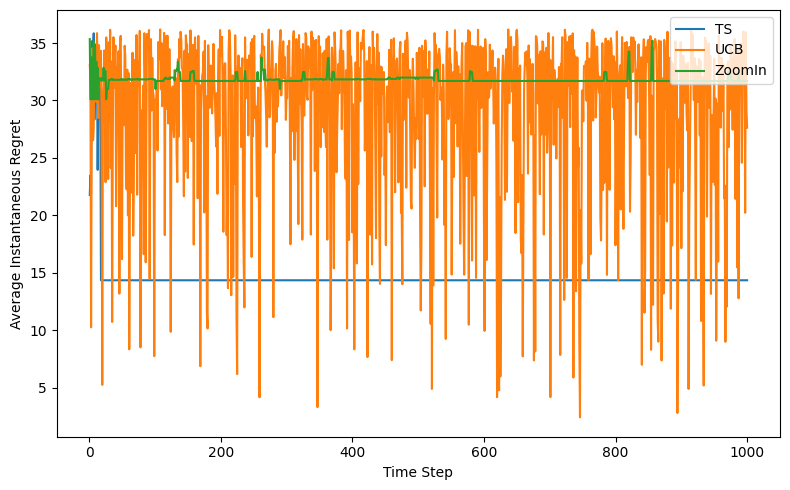

In [44]:
inst_df = pd.DataFrame(records)
inst_df["regret"] = inst_df.groupby(["run", "algorithm"])['regret'].diff().fillna(inst_df["regret"])

df_inst_avg = inst_df.groupby(['algorithm', 'time'])['regret'].mean().reset_index()
df_inst_avg.rename(columns={"regret": "avg_inst_regret"}, inplace=True)

df_inst_avg["avg_inst_regret"] = df_inst_avg["avg_inst_regret"].apply(ensure_scalar)

df_inst_avg = df_inst_avg.dropna(subset=["avg_inst_regret"])

df_inst_avg["avg_inst_regret"] = df_inst_avg["avg_inst_regret"].astype(float)

plot_instantaneous_regret(df_inst_avg)